In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import sys
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from help_functions import create_model, get_top_classes

In [18]:
IMAGE_DIMENSION = 64

### Select the training configuration

In [20]:
i = 1
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]

In [36]:
old_stdout = sys.stdout

log_file = open(config['results_and_checkpoints_folder'] + '/log.txt', 'w')
sys.stdout = log_file

In [37]:
print(config)
config

{'nr_classes': 20,
 'labels': 'naive',
 'class_weights': True,
 'basemodel': 'EfficientNetB0',
 'image_dimension': 64,
 'results_and_checkpoints_folder': 'train/1_naive_20classes_Trueweights_EfficientNetB0',
 'data_folder': 'data/split_dataframes_600k_33_labels_20220606'}

### Plot training metrics

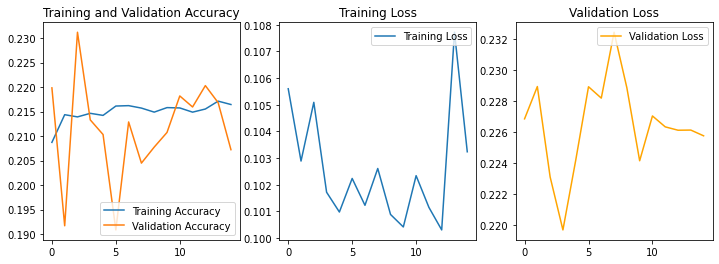

In [22]:
# Plot training metrics: loss & accuracy
training_metrics = pd.read_csv(config['results_and_checkpoints_folder'] + '/history.csv')

epochs = training_metrics.shape[0]

acc = training_metrics.accuracy.values
loss = training_metrics.loss.values

val_acc = training_metrics.val_accuracy.values
val_loss = training_metrics.val_loss.values

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(range(epochs), loss, label='Training Loss')
# plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1, 3, 3)
# plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Validation Loss')
plt.show()

In [38]:
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')
top_classes = get_top_classes(config['nr_classes'], test_df) # OBS: are they always the same as top classes of train_df? In the 10-case yes.

# Only keep rows which have either of the top classes
ids_x_labels = test_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
test_set_x_labels = test_df[ids_x_labels]
test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
test_df = test_set_x_labels.copy()

datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        # subset='validation',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(config['image_dimension'], config['image_dimension']),
        shuffle=False
        )

N_LABELS = len(test.class_indices)

<ipython-input-38-9b3c4519d4f0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


In [39]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Create model and load model weights
def create_model():
    efficient_net = EfficientNetB0(include_top=False, 
                                   weights='imagenet', 
                                   classes=config['nr_classes'],
                                   input_shape=(config['image_dimension'], config['image_dimension'], 3))

    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(config['nr_classes'], activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy'])

    model.summary()
    return model
model = create_model()
latest = tf.train.latest_checkpoint(config['results_and_checkpoints_folder'])
print(latest)
model.load_weights(latest)

In [25]:
from sklearn.metrics import classification_report

predictions = model.predict(test, verbose=1)


936/936 [==============================] - 60s 64ms/step


In [26]:
threshold = 0.5
y_pred = 1 * (predictions > threshold)
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


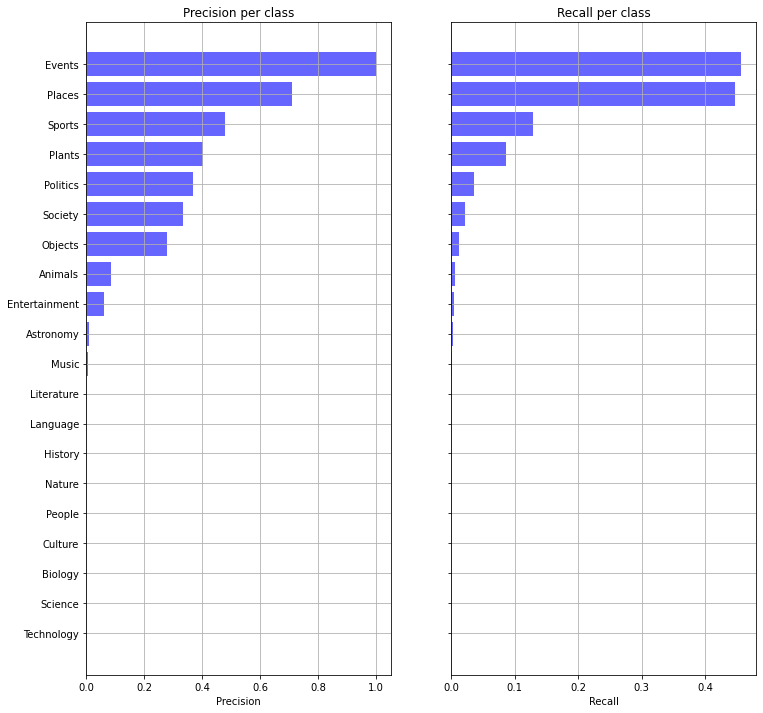

In [40]:
# N_CLASSES = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_LABELS), [None, None, None, None]))
print(metrics_df)

fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:N_LABELS])
sorted_precisions_per_class = metrics_df.precision[0:N_LABELS][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:N_LABELS])
sorted_recalls_per_class = metrics_df.recall[0:N_LABELS][sorted_indices_recall]

# Per-class accuracy
from collections import Counter
total = Counter()
correct = Counter()
for i in range(len(test.classes)):
    true_y = test.classes[i]
    for l in true_y:
        total[l]+=1
    predicted_y = np.argwhere(predictions[i]>=0.5)
    for p in predicted_y:
        if p[0] in true_y:
            correct[p[0]]+=1

name_id_map = test.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

for k in sorted(total.keys()):
    print(class_names[k].split(".")[-1], "{}/{} == {}".format(correct[k], total[k], round(correct[k]/total[k], 3)))
                
axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(N_LABELS))
axs[0].set_yticklabels(np.array(list(test.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)

axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(N_LABELS))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)
plt.savefig(config['results_and_checkpoints_folder'] + '/precision_recall.png')

#### ROC curve for each class

On micro and macro averaging: Micro- and macro-averages (for whatever metric) will compute slightly different things, and thus their interpretation differs. A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

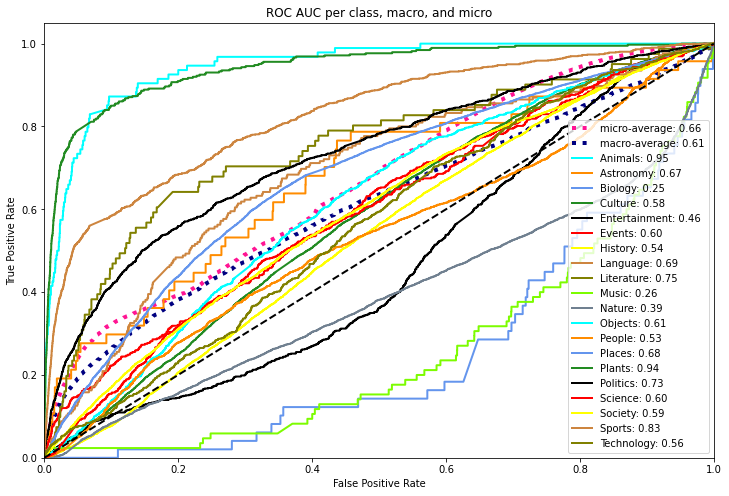

In [41]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw = 2
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_LABELS)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_LABELS):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_LABELS

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.figure(figsize=(12, 8))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average: { roc_auc['micro'] :0.2f}",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average: { roc_auc['macro'] :0.2f}",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "forestgreen", "black", "red", "yellow", "peru", "olive", "lawngreen", "slategray"])
for i, color in zip(range(N_LABELS), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label=f"{list(name_id_map.keys())[i]}: {roc_auc[i]:0.2f}"
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC per class, macro, and micro")
plt.legend(loc="lower right")
plt.savefig(config['results_and_checkpoints_folder'] + '/roc_curves.png')
plt.show()

In [ ]:
sys.stdout = old_stdout

log_file.close()